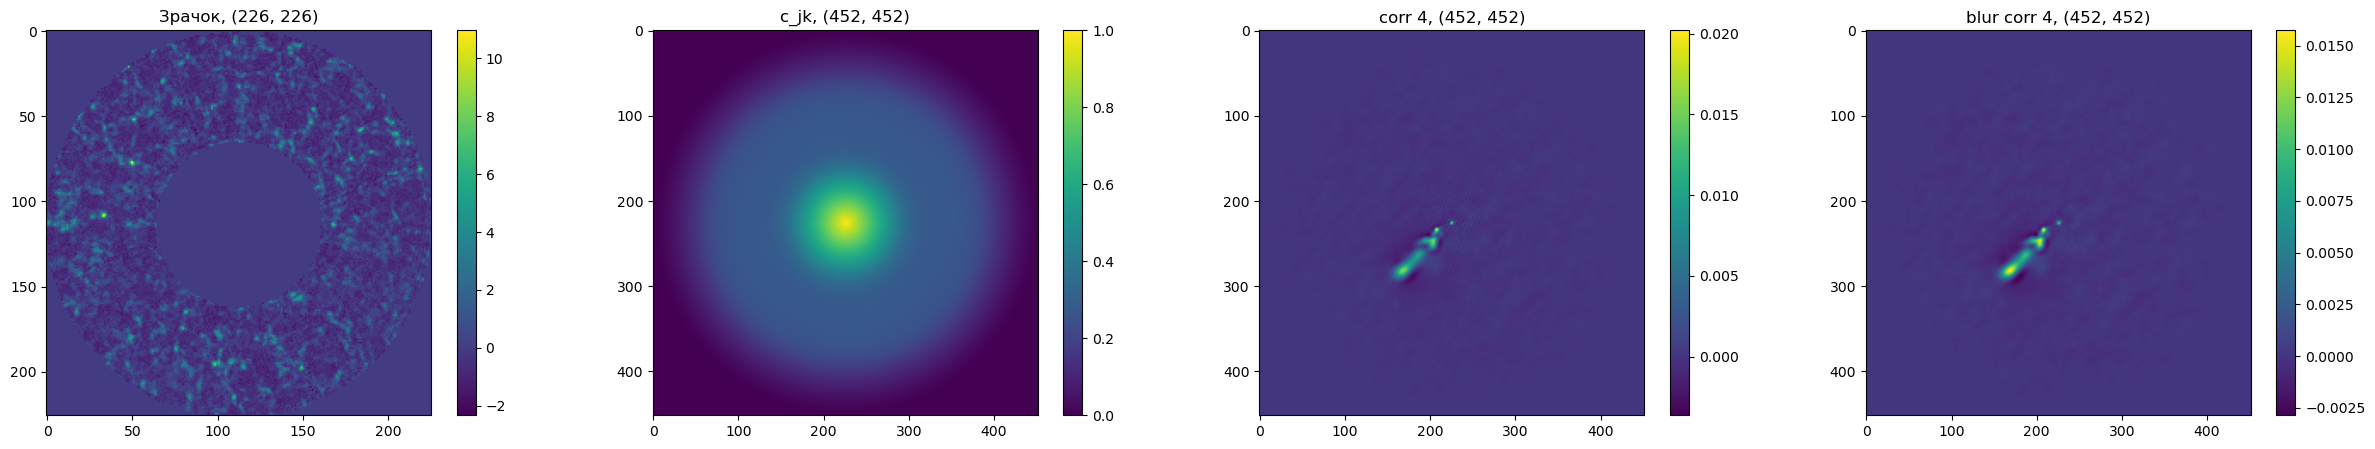

In [75]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit
from skimage.filters import threshold_multiotsu, threshold_otsu, median

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    if idx == (len(array) - 1):
        return idx, idx-1
    if idx == 0:
        return 1, 0
    else:
        if array[idx] > value:
            return idx, idx-1 
        if array[idx] < value:
            return idx+1, idx

def gamma_poly_se(X, Y, Vx, Vy, Cn2, z): 
    global cjk, t, a1, gammas, delta
    
    Cn2=Cn2*1e-14
    z=z*1000

    # мб дать как то обозначить приоритетность выбора? или че нибудь такое. или шаг типа сделать равнозначный как по
#     высоте, так и по мощности
    
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    
    lv = find_nearest(a1, z)[1]
    uv = find_nearest(a1, z)[0]
    
    res = gammas[lv] + (z - a1[lv])*((gammas[uv] - gammas[lv])/(a1[uv] - a1[lv]))
    
    res = (res/(1e-13))*Cn2
    res = shift(res, (-Ypix, Xpix), order=1)  

    res = res * cjk
    return res

# ----------- входные параметры
D = 2.5
latency = 4
data_dir = 'D:/astro/domecam'
gammas_type = 'blur'
lambda_=500*pow(10, -9) # нм


sec_per_frame = 0.01
t = sec_per_frame * latency
k = 2*np.pi/lambda_

# ---------- считывание зрачка, картины мерцаний, автокорреляции зрачка и гамм

if gammas_type == 'orig':
    data = np.loadtxt(f'{data_dir}/corr{latency}_orig.gz')
    gammas = np.load(f'{data_dir}/gammas_orig.npy')

if gammas_type == 'blur':
    data = np.loadtxt(f'{data_dir}/corr{latency}_blur.gz')
    gammas = np.load(f'{data_dir}/gammas_blur.npy')

pupil = np.loadtxt(f'{data_dir}/frame.gz')
cjk = np.loadtxt(f'{data_dir}/cjk.gz')
a1 = np.loadtxt(f'{data_dir}/z.gz')

# ------------ шаг для функции гамма
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)

delta = D/(pupil.shape[0]) # шаг по пикселю

# ------------------ распределение гамм


fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(np.loadtxt(f'{data_dir}/corr{latency}_orig.gz')), ax=ax3)
ax3.grid(False)
ax3.set_title(f'corr 4, {data.shape}')

fig.colorbar(ax4.imshow(np.loadtxt(f'{data_dir}/corr{latency}_blur.gz')), ax=ax4)
ax4.grid(False)
ax4.set_title(f'blur corr 4, {data.shape}')

def CLEAN(dirty, gain=None, thresh=None, niter=None, window=None):
    global t, delta
    st = time.perf_counter()
    comps = np.zeros(dirty.shape)
    res = np.array(dirty) 
    cl = np.zeros(dirty.shape)
    
    k = 5
    res2 = np.array(dirty)
    cl2 = np.zeros(dirty.shape)

    tmp = 0
    tmp_Vx = []
    tmp_Vy = []
    all_params = []
    for i in range(niter):
        my, mx = np.unravel_index(np.argmax(res), res.shape)
        mval=res[my, mx]*gain
        comps[my, mx]+=mval
        
        Vy = (dirty.shape[0]//2-my)*delta/t
        Vx = -(dirty.shape[1]//2-mx)*delta/t
        
        tmp_Vx.append(Vx)
        tmp_Vy.append(Vy)
                
        if i > 5\
        and tmp_Vx[i-4] == tmp_Vx[i] and tmp_Vx[i-3] == tmp_Vx[i] and tmp_Vx[i-2] == tmp_Vx[i] and tmp_Vx[i-1] == tmp_Vx[i]\
        and tmp_Vy[i-4] == tmp_Vy[i] and tmp_Vy[i-3] == tmp_Vy[i] and tmp_Vy[i-2] == tmp_Vy[i] and tmp_Vy[i-1] == tmp_Vy[i]:
            all_params = np.array(all_params)
            all_params = all_params[:-4, :]
            print('Stucked')
            break
        
        if int(Vx) == 0 and int(Vy) == 0:
            print('Dome turbulence')
            myParams = [0, 0, 15, 2]
            psf, params = multi_speckle_fit(myParams, ydata=res, window=window//2)
            print('-initial value:', res[my, mx])
            res -= psf*0.99
        else:
            myParams = [Vx, Vy, 1, (15+5*np.sin(np.random.uniform(-np.pi, np.pi)))]  
            psf, params = multi_speckle_fit(myParams, ydata=res, window=window)
            print('-initial value:', res[my, mx])
            res -= psf*gain
        
        cl += psf*gain
        all_params.append(params)
        print('-residual value:', res[my, mx])
        
        if (i+1)%k == 0:
            print('\nCheckpoint fitting...')
            fit, params2 = one_speckle_fit(all_params[i-(k-1):i+1], res2)
            res2 -= fit
            cl2 += fit
            
            plt.figure()
            plt.imshow(res2)
            plt.show()
            
            plt.figure()
            plt.imshow(cl2)
            plt.show()
        print(' ')
        
        tmp = i
        if np.max(res) < thresh:
            print('Thresh reached!')
            break
    print('Total iterations:', tmp+1)
    print('time:', time.perf_counter()-st)
    return comps, res, cl, np.array(all_params)


def multi_speckle_fit(params, ydata=None, window=None):
    global t, delta
    st=time.perf_counter()  
    def speckle_fit(params, ydata, window=None):
        k=window
        def _g(one_dim_x, *args): 
            arr = np.zeros(one_dim_x[0].shape)
            Vx = args[0]
            Vy = args[1]
            Cn2 = args[2]
            z = args[3]
            arr += gamma_poly_se(one_dim_x[0], one_dim_x[1], Vx, Vy, Cn2, z)[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k].ravel()
            return arr
        
        xcoord = params[0]
        ycoord = params[1]
        cr = ydata.shape[0]//2, ydata.shape[1]//2
        
        Xpix1 = int(xcoord*t/delta) + cr[1]
        Ypix1 = -int(ycoord*t/delta) + cr[0]
        
        fit = np.zeros(ydata.shape)
        ydata = ydata[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]
        
        plt.figure()
        plt.imshow(ydata)
        plt.colorbar()
        plt.show()
        
        x = np.linspace(-ydata.shape[1]//2, ydata.shape[1]//2-1, ydata.shape[1])
        y = np.linspace(-ydata.shape[0]//2, ydata.shape[0]//2-1, ydata.shape[0])
        X, Y = np.meshgrid(x, y)
        
        xdata = np.vstack((X.ravel(), Y.ravel()))
        
        ydata = ydata.ravel()

        bounds = [[-np.inf, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf]]
        popt, pcov = curve_fit(_g, xdata, ydata, p0=params, bounds=bounds)
        
        fit += gamma_poly_se(X, Y, *popt)        

        return fit, popt[0], popt[1], popt[2], popt[3]
        
    res = np.zeros(data.shape)
    print(f'Speckle fitting: {params[0]} {params[1]} {1e-14*params[2]} {1000*params[3]}')
    fit, Vx, Vy, Cn2, z = speckle_fit(params, ydata, window=window)
    
    xcoord = int(Vx*t/delta)
    ycoord = int(Vy*t/delta)
    res +=fit
#     res[(res.shape[0]//2 - ycoord) - fit.shape[0]//2:(res.shape[0]//2 - ycoord) + fit.shape[0]//2, 
#             (res.shape[1]//2 + xcoord) - fit.shape[1]//2:(res.shape[1]//2 + xcoord) + fit.shape[1]//2] += fit
        
    print(f'Fitted parametrs: {Vx:.2f} {Vy:.2f} {1e-14*Cn2} {1000*z}')
    print('time:', time.perf_counter()-st)    
    return res, [Vx, Vy, Cn2, z]

def one_speckle_fit(params=None, data=None): 
    def _g(M, *args): 
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//4):
            arr += gamma_poly_se(x, y, *args[i*4:i*4+4]).ravel()
        return arr
        
    p0 = [p for prms in params for p in prms]
        
    st=time.perf_counter()
       
    x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
    y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
    X, Y = np.meshgrid(x, y)

    fit = np.zeros(X.shape) 
    xdata = np.vstack((X.ravel(), Y.ravel())) 
    ydata = data.ravel()
        
    lb = [-np.inf, -np.inf, 0, 0]
    lb = np.tile(lb, len(p0)//4)
    ub = [np.inf, np.inf, np.inf, np.inf]
    ub = np.tile(ub, len(p0)//4)
        
    popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[lb, ub])

    for i in range(len(popt)//4):
        fit += gamma_poly_se(X, Y, *popt[i*4:i*4+4])

    print(f'Time: {time.perf_counter()-st:.4f}')

    for i in range(len(popt)//4):
        print(*popt[i*4:i*4+4])

    return fit, popt

Speckle fitting: -4.977876106194691 -2.2123893805309733 1e-14 13288.709219109094


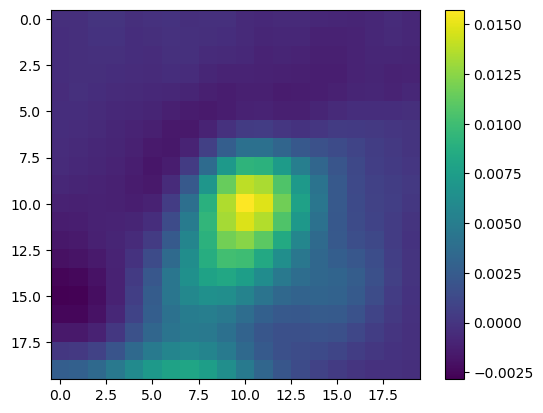

Fitted parametrs: -4.91 -2.73 2.285843237210212e-14 13440.297968963516
time: 0.6028458999999202
-initial value: 0.0157446962673446
-residual value: 0.005988724437991555
 
Speckle fitting: -15.763274336283187 -15.486725663716813 1e-14 15754.988530858926


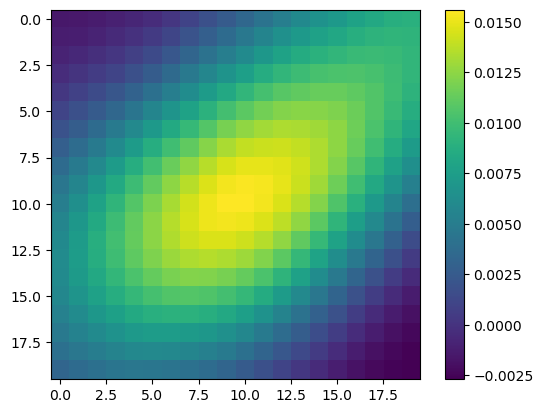

Fitted parametrs: -15.83 -15.31 2.31998654875484e-14 52332.156961937144
time: 0.5669507000002341
-initial value: 0.015597377923940697
-residual value: 0.00035167633813410447
 
Speckle fitting: -6.084070796460177 -5.807522123893805 1e-14 17717.57371069811


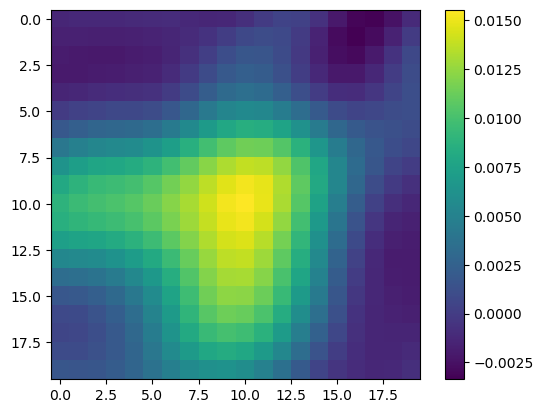

Fitted parametrs: -6.57 -6.24 1.9501967309425927e-14 27351.392085899504
time: 0.4340523000000758
-initial value: 0.015542226462744432
-residual value: 0.0012706442015329444
 
Dome turbulence
Speckle fitting: 0 0 1.5e-13 2000


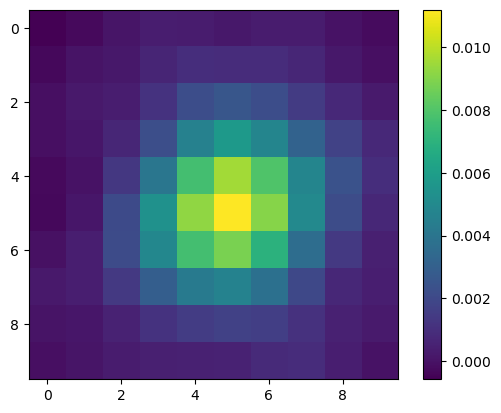

Fitted parametrs: 0.00 0.04 5.4487168525241787e-14 3854.5842447535865
time: 0.40669700000034936
-initial value: 0.01119841898473828
-residual value: 0.001752240471850755
 
Speckle fitting: -11.338495575221238 -11.061946902654867 1e-14 10000.02330739947


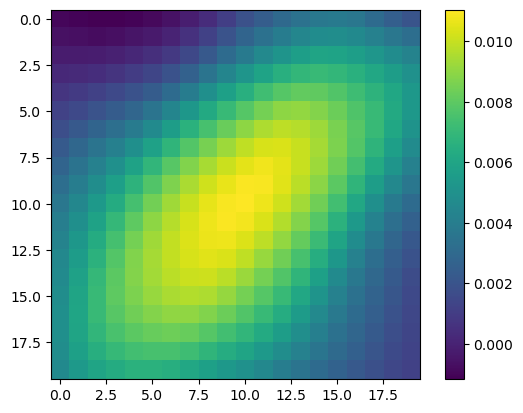

Fitted parametrs: -11.64 -11.52 9.144150487515932e-15 68777.87140264906
time: 0.5766180000000531
-initial value: 0.01104119304441742
-residual value: 0.00035688699417544927

Checkpoint fitting...
Time: 18.0096
-4.819363378231649 -2.5549222674829086 2.764995665664509 12.67368840066944
-15.943264015958869 -15.33967932354849 2.3918259842409912 51.898184836003196
-7.004376365099961 -6.494516375215761 1.1259857873920736 42.85510410042422
0.022826178451812947 0.0606194310367959 5.734191649980566 3.7613764136212886
-11.694661065154813 -11.540462000728317 1.0565488867760688 61.391279317052195


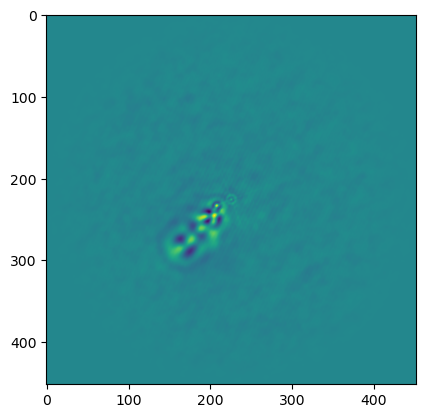

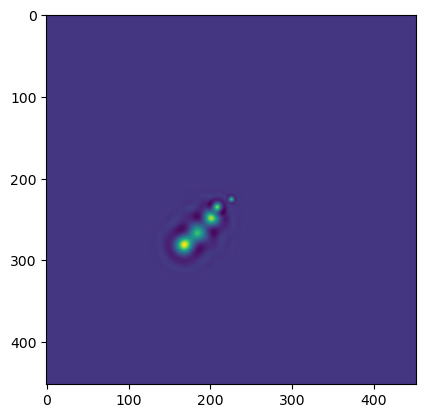

 
Speckle fitting: -9.126106194690266 -5.807522123893805 1e-14 19649.236218197053


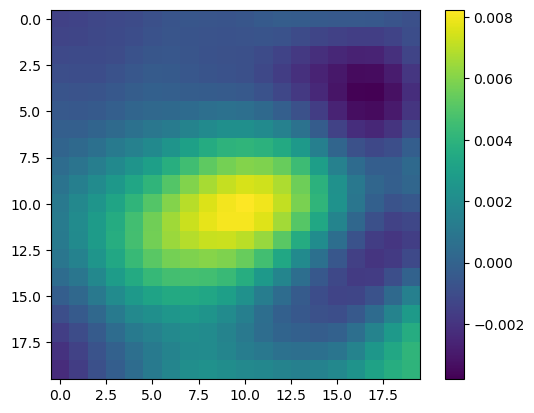

Fitted parametrs: -9.64 -6.09 1.839043276475684e-14 16108.387816812048
time: 0.5109495999995488
-initial value: 0.008232622602049836
-residual value: 0.001147783839449459
 
Speckle fitting: -4.977876106194691 -2.2123893805309733 1e-14 10604.848564210206


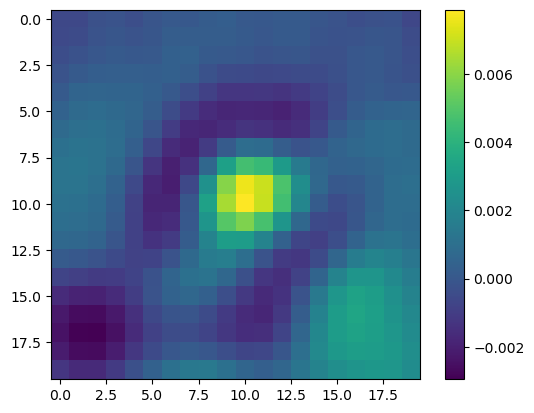

Fitted parametrs: -4.92 -2.15 1.1190854389554777e-13 2329.2560394889233
time: 0.9232277000000977
-initial value: 0.00787533800740292
-residual value: -0.00034644047493258626
 
Speckle fitting: -6.360619469026549 -8.019911504424778 1e-14 19999.198355683577


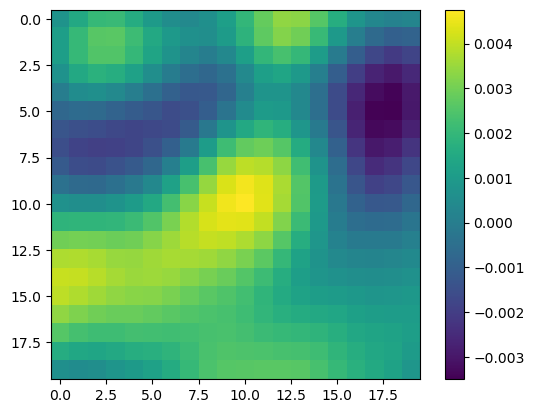

Fitted parametrs: -7.12 -9.29 4.431010410438388e-15 33690.731726390746
time: 0.6491641000002346
-initial value: 0.004759463698696436
-residual value: 0.00248234686876047
 
Thresh reached!
Total iterations: 8
time: 22.89174600000024


Text(0.5, 1.0, 'max: 0.0038, min: -0.0038')

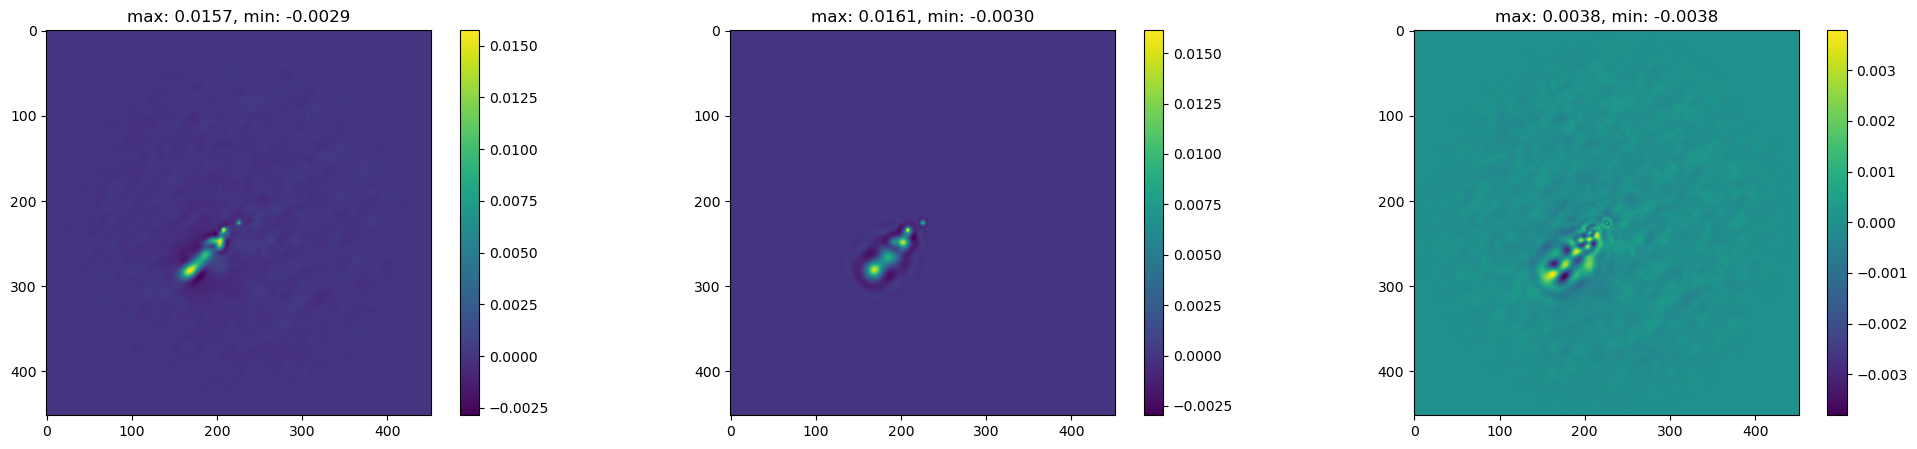

In [76]:
comps, residual, clean, params = CLEAN(data, gain=1, thresh=threshold_otsu(data), niter=50, window=10)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
fig.colorbar(ax.imshow(data), ax=ax) 
fig.colorbar(ax2.imshow(clean), ax=ax2) 
fig.colorbar(ax3.imshow(residual), ax=ax3) 
ax.set_title(f'max: {np.max(data):.4f}, min: {np.min(data):.4f}') 
ax2.set_title(f'max: {np.max(clean):.4f}, min: {np.min(clean):.4f}') 
ax3.set_title(f'max: {np.max(residual):.4f}, min: {np.min(residual):.4f}')

0.0006722146020570495 (65, 4)
4.3624161073825505 4.281332398719393


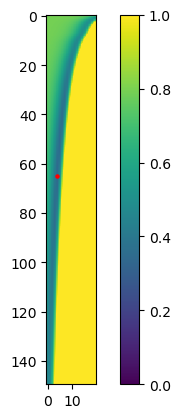

In [31]:
k_height=150
k_width=20
R=np.zeros((k_height, k_width))
h = np.linspace(0, 10, k_height)
c = np.geomspace(1, 1000, k_width)
for i in range(k_height):
    for j in range(k_width):
        R[i, j] = np.sum(pow(data - gamma_poly_se(X, Y, 0, 0, c[j], h[i]), 2)[211:241,211:241])

plt.imshow(np.log(R), vmin=-8, vmax=-6)
plt.scatter(np.unravel_index(np.argmin(R), R.shape)[1], np.unravel_index(np.argmin(R), R.shape)[0], color='red', s=5)
plt.colorbar()
print(R[np.unravel_index(np.argmin(R), R.shape)], np.unravel_index(np.argmin(R), R.shape))
print(h[np.unravel_index(np.argmin(R), R.shape)[0]], c[np.unravel_index(np.argmin(R), R.shape)[1]])

#двумерная карта невязки, где по осям ОУ размечено разбиение по высотам, а по ОХ - разбиение по мощности. в каждой ячейке
# матрицы содержится значение R = sum(data-model)^2. Видно, что при меньшем окне при подсчете суммы, невязка принимает
# правильное значение минимума. В то время как при подсчете в полном окне, минимум явно не прослеживается и поэтому 
# минимизация выдает такое значение

# короче: дальше мне нужно реализовать КЛИН с использованием окна

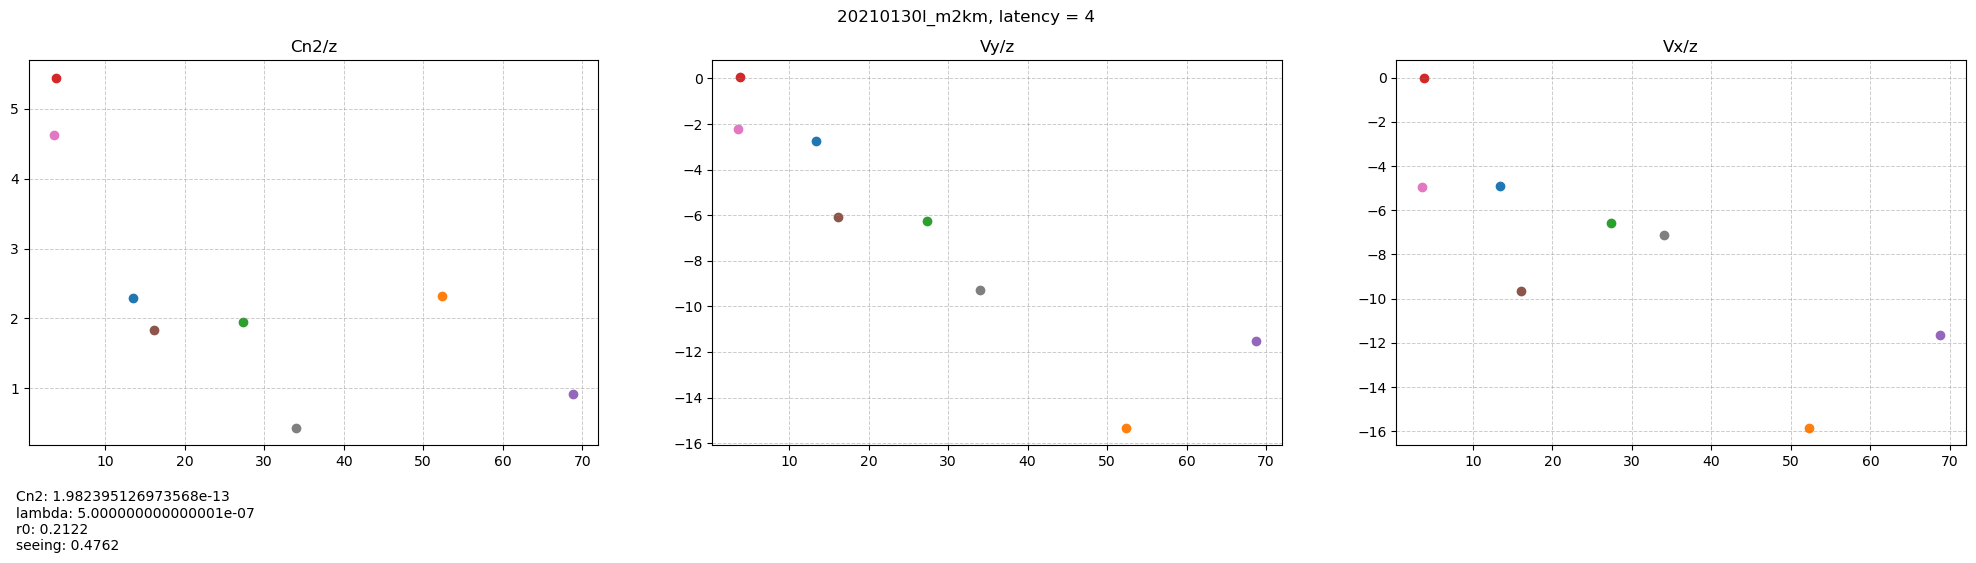

In [74]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 

all_cn2 = []
for i in range(params.shape[0]):
    all_cn2.append(params[i][2])
    
sum_cn2 = np.sum(all_cn2)*1e-14
lambda_ = 500 * pow(10, -9)
r0 = pow(0.423 * pow((2*np.pi/lambda_), 2) * sum_cn2, -3/5)
seeing = 206265 * 0.98 * lambda_/r0

for i in params:
    ax.scatter(i[3], i[2])
    ax2.scatter(i[3], i[1])
    ax3.scatter(i[3], i[0])
ax.set_title('Cn2/z')
ax2.set_title('Vy/z')
ax3.set_title('Vx/z')
ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax2.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax3.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
fig.text(0.12, -0.1, f'\nCn2: {sum_cn2}\nlambda: {lambda_}\nr0: {r0:.4f}\nseeing: {seeing:.4f}')
fig.suptitle('20210130l_m2km, latency = 4')
# fig.savefig('D:/astro/profile1.png', bbox_inches='tight')
print('')

In [ ]:
params
new_params = params.copy()

new_params[:, 0] = np.vectorize(int)(new_params[:, 0])
new_params[:, 1] = np.vectorize(int)(new_params[:, 1])
new_params[:, 3] = np.vectorize(int)(new_params[:, 3])

new_params2 = []
for i in range(new_params.shape[0]):
    vx = new_params[i][0]
    vy = new_params[i][1]
    tmp=[]
    for j in range(new_params.shape[0]):
        if vx == new_params[j][0] and vy == new_params[j][1]:
            tmp.append(new_params[j])
    tmp = np.array(tmp)
    new_params2.append(np.mean(tmp, axis=0))
    del tmp
    
new_params2 = np.unique(np.array(new_params2), axis=0)
print('initial params:', new_params.shape, '\ncleaned params:', new_params2.shape)
print(new_params2)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
for i in new_params2:
    ax.scatter(i[3], i[2])
    ax2.scatter(i[3], i[1])
    ax3.scatter(i[3], i[0])
ax.set_title('Cn2/z')
ax2.set_title('Vy/z')
ax3.set_title('Vx/z')
ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax2.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax3.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

In [ ]:
# params

fit, params2 = one_speckle_fit(params[0:3], data)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
fig.colorbar(ax.imshow(data), ax=ax) 
fig.colorbar(ax2.imshow(fit), ax=ax2) 
fig.colorbar(ax3.imshow(data-fit), ax=ax3) 

In [ ]:
p3 = np.reshape(params2, (-1, 4))
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
for i in p3:
    ax.scatter(i[3], i[2])
    ax2.scatter(i[3], i[1])
    ax3.scatter(i[3], i[0])
ax.set_title('Cn2/z')
ax2.set_title('Vy/z')
ax3.set_title('Vx/z')
ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax2.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax3.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

p3